<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?






1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>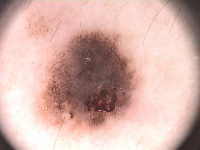</td><td>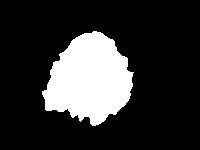</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
from skimage.io import imread
import os
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
from torch.nn import MaxUnpool2d
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader


from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
!pip install googledrivedownloader

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1VtEDXKLJSe0-x3RnQvlvZZv9bqKMte0h',
                                    dest_path='./PH2Dataset.rar',
                                    unzip=False)

In [ ]:
get_ipython().system_raw(f"unrar x {dataset_path}")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images from {len(lesions)} lesions')

Loaded 200 images from 200 lesions


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

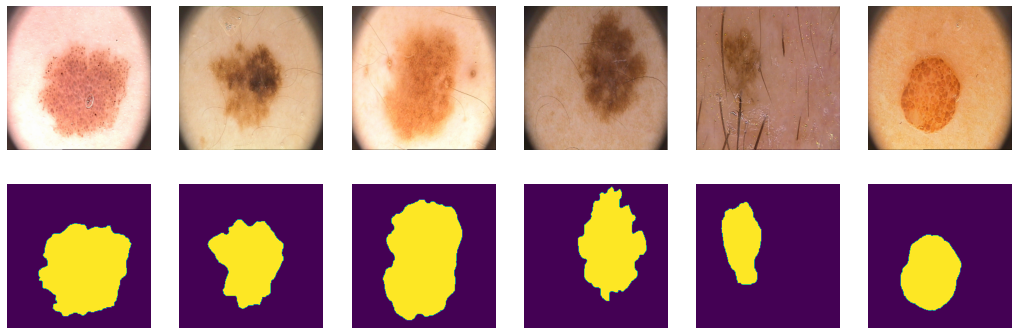

In [ ]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
np.random.seed(42)
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(f'train: {len(tr)}\nvalidation: {len(val)}\ntest: {len(ts)}')

train: 100
validation: 50
test: 50


In [ ]:
def random_hflip(x, y):
    if np.random.choice([0,1]):
      return TF.hflip(x), TF.hflip(y)
    else:
      return x, y

In [ ]:
def random_vflip(x, y):
    if np.random.choice([0,1]):
      return TF.vflip(x), TF.vflip(y)
    else:
      return x, y

In [ ]:
class LesionDataset(Dataset):
    def __init__(self, data, train=False):
        super().__init__()
        
        self.data = data
        self.len_ = len(self.data)
        self.train = train

        for i in range(len(data)):
            self.data[i] = TF.to_tensor(data[i][0]), TF.to_tensor(data[i][1])

    def __len__(self):
        return self.len_

    def __getitem__(self, index):
        x, y = self.data[index]
        if self.train:
            x, y = random_hflip(x, y)
            x, y = random_vflip(x, y)

        return x, y

In [ ]:
batch_size = 25

data_tr = DataLoader(LesionDataset(list(zip(X[tr], Y[tr, ..., np.newaxis])), train=True), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(LesionDataset(list(zip(X[val], Y[val, ..., np.newaxis]))),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(LesionDataset(list(zip(X[ts], Y[ts, ..., np.newaxis]))),
                     batch_size=batch_size, shuffle=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
!nvidia-smi

cuda
Wed May 19 13:14:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+--

## Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.



### SegNet [2 балла]



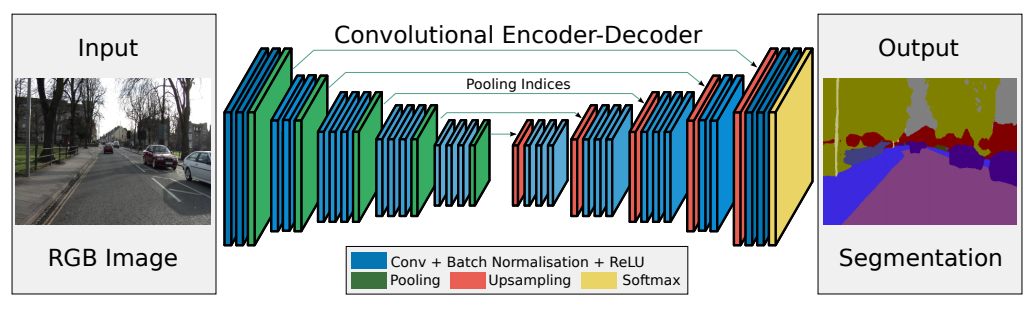

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [ ]:
def conv_layer(chann_in, chann_out, kernel_size=3, padding_size=0, padding_mode='zeros', stride=1):
    layer = nn.Sequential(
        nn.Conv2d(chann_in, chann_out, kernel_size=kernel_size, 
                  padding=padding_size, padding_mode=padding_mode, stride=stride),
        nn.BatchNorm2d(chann_out),
        nn.ReLU()
    )
    return layer

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            conv_layer(3, 16, 3, 1, 'reflect'),
            conv_layer(16, 16, 3, 1, 'reflect'),
        )
        self.pool0 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices=True)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            conv_layer(16, 32, 3, 1, 'reflect'),
            conv_layer(32, 32, 3, 1, 'reflect'),
        )
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            conv_layer(32, 64, 3, 1, 'reflect'),
            conv_layer(64, 64, 3, 1, 'reflect'),
        )
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            conv_layer(64, 128, 3, 1, 'reflect'),
            conv_layer(128, 128, 3, 1, 'reflect'),
        )
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = conv_layer(128, 128, 3, 1, 'reflect')

        # decoder (upsampling)
        self.upsample0 = MaxUnpool2d(2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            conv_layer(128, 128, 3, 1, 'reflect'),
            conv_layer(128, 64, 3, 1, 'reflect'),
        )
        self.upsample1 = MaxUnpool2d(2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            conv_layer(64, 64, 3, 1, 'reflect'),
            conv_layer(64, 32, 3, 1, 'reflect'),
        )
        self.upsample2 = MaxUnpool2d(2, stride=2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            conv_layer(32, 32, 3, 1, 'reflect'),
            conv_layer(32, 16, 3, 1, 'reflect'),
        )
        self.upsample3 = MaxUnpool2d(2, stride=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            conv_layer(16, 16, 3, 1, 'reflect'),
            nn.Conv2d(16, 1, kernel_size=3, 
                      padding=1, padding_mode='reflect', stride=1), # no activation
        )

    def forward(self, x):
        # encoder
        x, i0 = self.pool0(self.enc_conv0(x))
        x, i1 = self.pool1(self.enc_conv1(x))
        x, i2 = self.pool2(self.enc_conv2(x))
        x, i3 = self.pool3(self.enc_conv3(x))

        # bottleneck
        x = self.bottleneck_conv(x)

        # decoder
        x = self.dec_conv0(self.upsample0(x, i3))
        x = self.dec_conv1(self.upsample1(x, i2))
        x = self.dec_conv2(self.upsample2(x, i1)) 
        x = self.dec_conv3(self.upsample3(x, i0))  # no activation
        return x

In [ ]:
class conv2DBatchNormRelu(nn.Module):
     def __init__(self,in_channels,out_channels,kernel_size,stride,padding,
                  bias=True,dilation=1,is_batchnorm=True):
         super(conv2DBatchNormRelu,self).__init__()
         if is_batchnorm:
             self.cbr_unit=nn.Sequential(
                 nn.Conv2d(in_channels,out_channels,kernel_size=kernel_size,stride=stride,padding=padding,
                           bias=bias,dilation=dilation),
                 nn.BatchNorm2d(out_channels),
                 nn.ReLU(inplace=True),
             )
         else:
             self.cbr_unit=nn.Sequential(
                 nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding,
                           bias=bias, dilation=dilation),
                 nn.ReLU(inplace=True)
             )
 
     def forward(self,inputs):
         outputs=self.cbr_unit(inputs)
         return outputs
 
class segnetDown2(nn.Module):
     def __init__(self,in_channels,out_channels):
         super(segnetDown2,self).__init__()
         self.conv1=conv2DBatchNormRelu(in_channels,out_channels,kernel_size=3,stride=1,padding=1)
         self.conv2=conv2DBatchNormRelu(out_channels,out_channels,kernel_size=3,stride=1,padding=1)
         self.maxpool_with_argmax=nn.MaxPool2d(kernel_size=2,stride=2,return_indices=True)
 
     def forward(self,inputs):
         outputs=self.conv1(inputs)
         outputs=self.conv2(outputs)
         unpooled_shape=outputs.size()
         outputs,indices=self.maxpool_with_argmax(outputs)
         return outputs,indices,unpooled_shape
 
class segnetDown3(nn.Module):
     def __init__(self,in_channels,out_channels):
         super(segnetDown3,self).__init__()
         self.conv1=conv2DBatchNormRelu(in_channels,out_channels,kernel_size=3,stride=1,padding=1)
         self.conv2=conv2DBatchNormRelu(out_channels,out_channels,kernel_size=3,stride=1,padding=1)
         self.conv3=conv2DBatchNormRelu(out_channels,out_channels,kernel_size=3,stride=1,padding=1)
         self.maxpool_with_argmax=nn.MaxPool2d(kernel_size=2,stride=2,return_indices=True)
 
     def forward(self,inputs):
         outputs=self.conv1(inputs)
         outputs=self.conv2(outputs)
         outputs=self.conv3(outputs)
         unpooled_shape=outputs.size()
         outputs,indices=self.maxpool_with_argmax(outputs)
         return outputs,indices,unpooled_shape
 
 
class segnetUp2(nn.Module):
     def __init__(self,in_channels,out_channels):
         super(segnetUp2,self).__init__()
         self.unpool=nn.MaxUnpool2d(2,2)
         self.conv1=conv2DBatchNormRelu(in_channels,out_channels,kernel_size=3,stride=1,padding=1)
         self.conv2=conv2DBatchNormRelu(out_channels,out_channels,kernel_size=3,stride=1,padding=1)
 
     def forward(self,inputs,indices,output_shape):
         outputs=self.unpool(inputs,indices=indices,output_size=output_shape)
         outputs=self.conv1(outputs)
         outputs=self.conv2(outputs)
         return outputs

class segnetUp3(nn.Module):
     def __init__(self,in_channels,out_channels):
         super(segnetUp3,self).__init__()
         self.unpool=nn.MaxUnpool2d(2,2)
         self.conv1=conv2DBatchNormRelu(in_channels,out_channels,kernel_size=3,stride=1,padding=1)
         self.conv2=conv2DBatchNormRelu(out_channels,out_channels,kernel_size=3,stride=1,padding=1)
         self.conv3=conv2DBatchNormRelu(out_channels,out_channels,kernel_size=3,stride=1,padding=1)
 
     def forward(self,inputs,indices,output_shape):
         outputs=self.unpool(inputs,indices=indices,output_size=output_shape)
         outputs=self.conv1(outputs)
         outputs=self.conv2(outputs)
         outputs=self.conv3(outputs)
         return outputs

In [ ]:
class segnet(nn.Module):
     def __init__(self,in_channels=3,num_classes=1):
         super(segnet,self).__init__()
         self.down1=segnetDown2(in_channels=in_channels,out_channels=64)
         self.down2=segnetDown2(64,128)
         self.down3=segnetDown3(128,256)
         self.down4=segnetDown3(256,512)
         self.down5=segnetDown3(512,512)
 
         self.up5=segnetUp3(512,512)
         self.up4=segnetUp3(512,256)
         self.up3=segnetUp3(256,128)
         self.up2=segnetUp2(128,64)
         self.up1=segnetUp2(64,64)
         self.finconv=conv2DBatchNormRelu(64,num_classes,3,1,1)
 
     def forward(self,inputs):
         down1,indices_1,unpool_shape1=self.down1(inputs)
         down2,indices_2,unpool_shape2=self.down2(down1)
         down3,indices_3,unpool_shape3=self.down3(down2)
         down4,indices_4,unpool_shape4=self.down4(down3)
         down5,indices_5,unpool_shape5=self.down5(down4)
 
         up5=self.up5(down5,indices=indices_5,output_shape=unpool_shape5)
         up4=self.up4(up5,indices=indices_4,output_shape=unpool_shape4)
         up3=self.up3(up4,indices=indices_3,output_shape=unpool_shape3)
         up2=self.up2(up3,indices=indices_2,output_shape=unpool_shape2)
         up1=self.up1(up2,indices=indices_1,output_shape=unpool_shape1)
         outputs=self.finconv(up1)
 
         return outputs

### Метрика 

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

---

### Функция потерь [1 балл]



Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_pred, y_real):
    return torch.mean(torch.clamp(y_pred, min=0)-y_pred*y_real+torch.log(1+torch.exp(-torch.abs(y_pred))))

### Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = model(data.to(device)) > 0.5
    return Y_pred

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    X, Y = None, None
    for X_batch, Y_label in data:
        if X is None:
            X, Y = X_batch, Y_label
        else: 
            X = torch.cat([X, X_batch], dim=0)
            Y = torch.cat([Y, Y_label], dim=0)

    Y_pred = predict(model, X.to(device))
    return metric(Y_pred, Y.to(device)).mean().item()

---

### Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
def plot_loss(losses, scores):
    fig, ax = plt.subplots(1, 2, figsize=(14, 7))

    ax[0].plot(losses[0], label="train_loss")
    ax[0].plot(losses[1], label="val_loss")
    ax[0].legend(loc='best')
    ax[0].set_xlabel("epochs")
    ax[0].set_ylabel("loss")
    ax[0].grid(which="both")

    ax[1].plot(scores[0], label="train_score")
    ax[1].plot(scores[1], label="val_score")
    ax[1].legend(loc='best')
    ax[1].set_xlabel("epochs")
    ax[1].set_ylabel("loss")
    ax[1].grid(which="both")

    plt.show()

In [ ]:
PATH_TO_PARENT = '/content/drive/MyDrive/DLS/segmentation'

def save_model(model, optim, name, epoch, losses, metrics):
    description = f"{model}\n\n{optim}"
    state = {
        'model_state': model.state_dict(),
        'optim_state': optim.state_dict(),
        'losses': losses,
        'metrics': metrics,
        'epoch': epoch,
        'description': description
    }
    os.makedirs(f"{PATH_TO_PARENT}/saved", exist_ok=True)
    torch.save(state, f"{PATH_TO_PARENT}/saved/{name}.pth")

def load_model(model, optim, name, verbose=False):
    state = torch.load(f"{PATH_TO_PARENT}/saved/{name}.pth")
    description = state['description']
    if verbose:
        print('Loading model:')
        print(description)
    model.load_state_dict(state['model_state'])
    optim.load_state_dict(state['optim_state'])
    epoch = state['epoch']
    losses = state['losses']
    metrics = state['metrics']
    return epoch, losses, metrics

In [ ]:
def train(model, opt, loss_fn, metric, epochs, data_tr, data_val, scheduler=None, name=""):
    X_val, Y_val = next(iter(data_val))
    losses = []
    val_losses = []
    scores = []
    val_scores = []

    max_val_score = 0

    for epoch in range(epochs):
        avg_loss = 0
        avg_val_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)

            loss = loss_fn(Y_pred, Y_batch) # forward-pass
            loss.backward() # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)


        model.eval()
        for X_batch, Y_batch in data_val:
            with torch.no_grad():
              # to device
              X_batch = X_batch.to(device)
              Y_batch = Y_batch.to(device)

              # forward
              Y_pred = model(X_batch)

              val_loss = loss_fn(Y_pred, Y_batch) # forward-pass

              # calculate loss to show the user
              avg_val_loss += val_loss / len(data_val)


        if scheduler is not None:
            scheduler.step(avg_val_loss)
        
        losses += [avg_loss.item()]
        val_losses += [avg_val_loss.item()]
        scores += [score_model(model, iou_pytorch, data_tr)]
        val_scores += [score_model(model, iou_pytorch, data_val)]


        if name != "":
            if max_val_score < val_scores[-1]:
                max_val_score = val_scores[-1]
                save_model(model, optim, f'{name}_best', epoch, (losses, val_losses), (scores, val_scores))

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model(X_val.to(device)).cpu().detach().numpy() # detach and put into cpu

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle(f'{epoch+1}/{epochs}\nloss: {avg_loss}\nval_loss: {avg_val_loss}')
        plt.subplots_adjust(top=0.7)
        plt.show()

    if name != "":
        save_model(model, optim, name, epochs, (losses, val_losses), (scores, val_scores))

    return losses, val_losses, scores, val_scores

### Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [ ]:
model = SegNet().to(device)

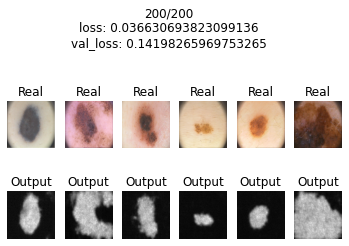

In [ ]:
max_epochs = 200
optim = torch.optim.AdamW(model.parameters(), lr=0.5*1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min', cooldown=5, factor=0.5, patience=15)
losses, val_losses, scores, val_scores = train(model, optim, bce_loss, iou_pytorch, max_epochs, data_tr, data_val, scheduler=scheduler, name='SegNet_bce_loss')

In [ ]:
score_model(model, iou_pytorch, data_val)

0.7619999647140503

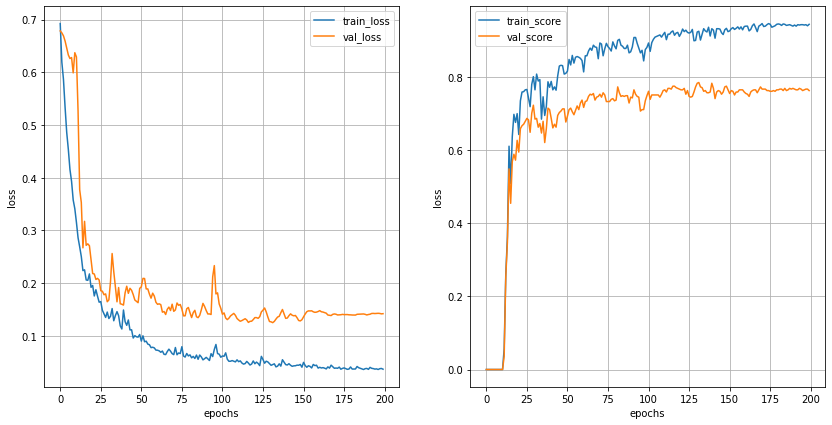

In [ ]:
plot_loss((losses, val_losses), (scores, val_scores))

Ответьте себе на вопрос: не переобучается ли моя модель?

*Ответ*: Переобучается, но в целом нормально при <100 эпох.

---

### Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [ ]:
def dice_loss(y_pred, y_real):
    SMOOTH = 1e-2
    y_pred = torch.sigmoid(y_pred)
    num = 2*y_real*y_pred+SMOOTH
    den = y_real+y_pred+SMOOTH
    res = 1-(num/den).mean()
    return res 

Проводим тестирование:

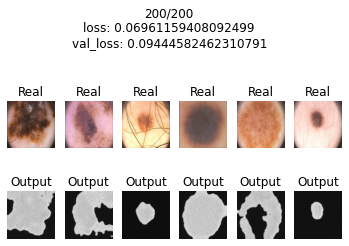

In [ ]:
model_dice = SegNet().to(device)

max_epochs = 200
optim = torch.optim.AdamW(model_dice.parameters(), lr=0.5*1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min', cooldown=5, factor=0.5, patience=15)
losses, val_losses, scores, val_scores = train(model_dice, optim, dice_loss, iou_pytorch, max_epochs, data_tr, data_val, scheduler=scheduler, name='SeGNet_dice_loss')

In [ ]:
score_model(model_dice, iou_pytorch, data_val)

0.7359999418258667

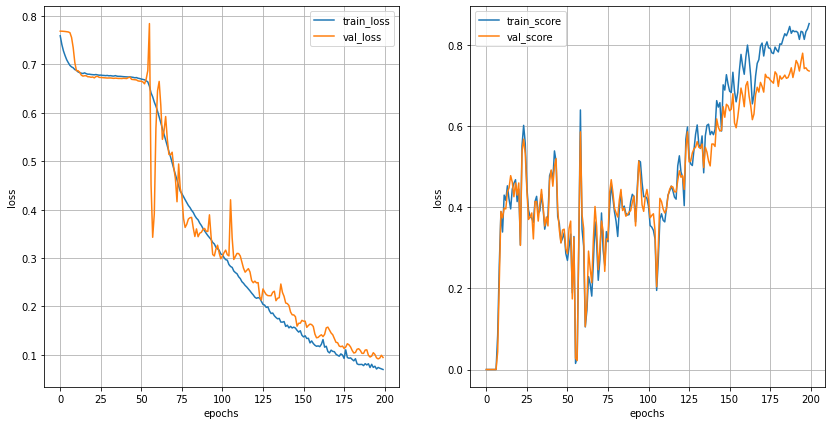

In [ ]:
plot_loss((losses, val_losses), (scores, val_scores))

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_pred, y_real, eps = 1e-8, gamma = 2):
    y_pred =  torch.clamp(torch.sigmoid(y_pred), min=eps, max=1-eps)
    return -torch.mean( (1-y_pred)**gamma*y_real*torch.log(y_pred) + (1-y_real)*torch.log(1-y_pred) )

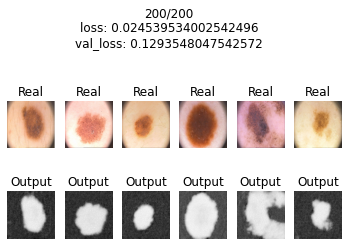

In [ ]:
model_focal = SegNet().to(device)

max_epochs = 200
optim = torch.optim.AdamW(model_focal.parameters(), lr=0.5*1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min', cooldown=5, factor=0.5, patience=15)
losses, val_losses, scores, val_scores = train(model_focal, optim, focal_loss, iou_pytorch, max_epochs, data_tr, data_val, scheduler=scheduler, name='SegNet_focal_loss')

In [ ]:
score_model(model_focal, iou_pytorch, data_val)

0.7419999241828918

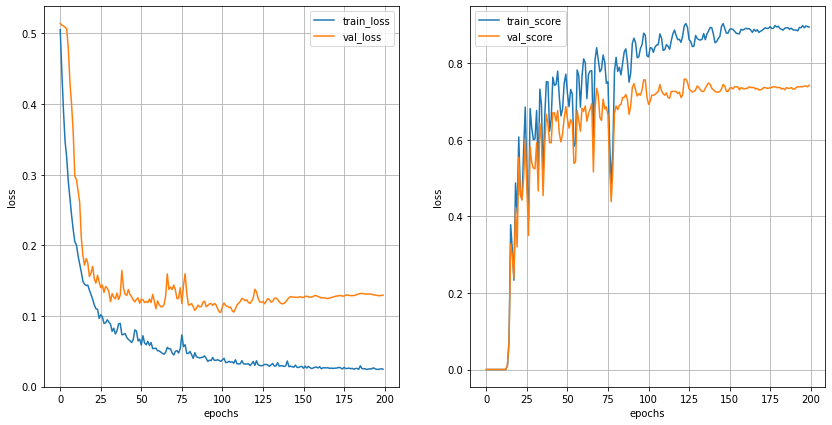

In [ ]:
plot_loss((losses, val_losses), (scores, val_scores))

---

### [BONUS] Мир сегментационных лоссов [5 баллов]



В данном блоке реализован лосс из статьи:

[Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

In [ ]:
def ss_loss(y_pred, y_real):
    y_pred = torch.sigmoid(y_pred)

    unfold = nn.Unfold(3, stride=3, padding=1)
    fold = nn.Fold([256, 256], stride=3, padding=1, kernel_size=3)

    # Normalization of 3x3 cells over 256x256 image
    SMOOTH = 0.01
    a_uf = unfold(y_real)
    b_uf = unfold(y_pred.detach())
    c = (a_uf-a_uf.mean(dim=1).unsqueeze(1)+SMOOTH)/(a_uf.std(dim=1, unbiased=False).unsqueeze(1)+SMOOTH)
    d = (b_uf-b_uf.mean(dim=1).unsqueeze(1)+SMOOTH)/(b_uf.std(dim=1, unbiased=False).unsqueeze(1)+SMOOTH)

    c = fold(c)
    d = fold(d)

    # Structure comparison
    e = torch.abs(c-d)
    e_max = e.max()
    beta = 0.1

    # Weights to binary cross entropy
    is_hard = e > e_max*beta
    hard_examples = is_hard.sum()
    w = (is_hard * e)

    ssl = nn.BCELoss(reduction='sum', weight=w)

    return ssl(y_pred, y_real)/hard_examples

In [ ]:
def bce_ss_loss(y_pred, y_real, ssl_weight=0.5):
    return ssl_weight*ss_loss(y_pred, y_real) + (1-ssl_weight)*bce_loss(y_pred, y_real)

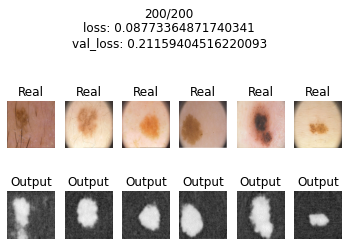

In [ ]:
model_ssl = SegNet().to(device)

max_epochs = 200
optim = torch.optim.AdamW(model_ssl.parameters(), lr=0.5*1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min', cooldown=5, factor=0.5, patience=15)
losses, val_losses, scores, val_scores = train(model_ssl, optim, bce_ss_loss, iou_pytorch, max_epochs, data_tr, data_val, scheduler, name='SegNet_ss_loss')

In [ ]:
score_model(model_ssl, iou_pytorch, data_val)

0.777999997138977

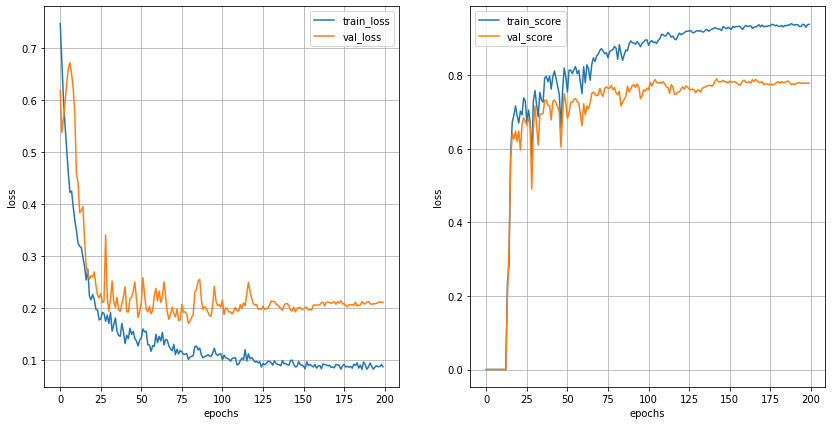

In [ ]:
plot_loss((losses, val_losses), (scores, val_scores))

---

### U-Net [2 балла]



[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

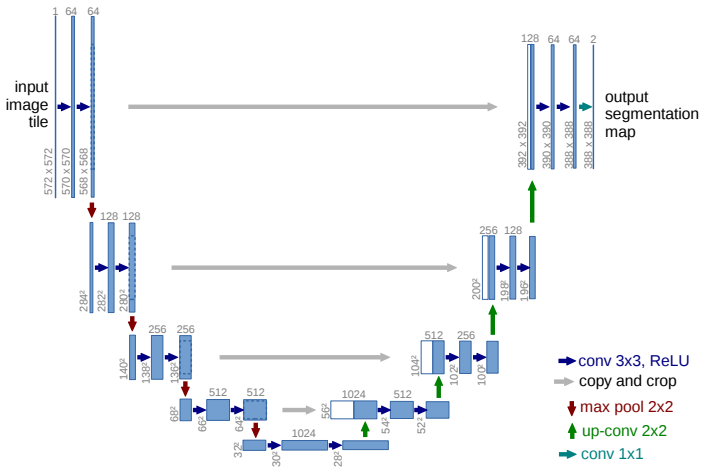

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            conv_layer(3, 16, 3, 1, 'reflect'),
            conv_layer(16, 16, 3, 1, 'reflect'),
        )
        self.pool0 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices=True)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            conv_layer(16, 32, 3, 1, 'reflect'),
            conv_layer(32, 32, 3, 1, 'reflect'),
        )
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            conv_layer(32, 64, 3, 1, 'reflect'),
            conv_layer(64, 64, 3, 1, 'reflect'),
        )
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            conv_layer(64, 128, 3, 1, 'reflect'),
            conv_layer(128, 128, 3, 1, 'reflect'),
        )
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = conv_layer(128, 128, 3, 1, 'reflect')

        # decoder (upsampling)
        self.upsample0 = MaxUnpool2d(2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            conv_layer(256, 128, 3, 1, 'reflect'),
            conv_layer(128, 64, 3, 1, 'reflect'),
        )
        self.upsample1 = MaxUnpool2d(2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            conv_layer(128, 64, 3, 1, 'reflect'),
            conv_layer(64, 32, 3, 1, 'reflect'),
        )
        self.upsample2 = MaxUnpool2d(2, stride=2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            conv_layer(64, 32, 3, 1, 'reflect'),
            conv_layer(32, 16, 3, 1, 'reflect'),
        )
        self.upsample3 = MaxUnpool2d(2, stride=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            conv_layer(32, 16, 3, 1, 'reflect'),
            nn.Conv2d(16, 1, kernel_size=3, 
                      padding=1, padding_mode='reflect', stride=1), # no activation
        )

    def forward(self, x):
        # encoder
        conv0 = self.enc_conv0(x)
        x, i0 = self.pool0(conv0)

        conv1 = self.enc_conv1(x)
        x, i1 = self.pool1(conv1)

        conv2 = self.enc_conv2(x)
        x, i2 = self.pool2(conv2)

        conv3 = self.enc_conv3(x)
        x, i3 = self.pool3(conv3)

        # bottleneck
        x = self.bottleneck_conv(x)

        # decoder
        x = self.upsample0(x, i3)
        x = torch.cat([x, conv3], dim=1)
        x = self.dec_conv0(x)

        x = self.upsample1(x, i2)
        x = torch.cat([x, conv2], dim=1)
        x = self.dec_conv1(x)

        x = self.upsample2(x, i1)
        x = torch.cat([x, conv1], dim=1)
        x = self.dec_conv2(x)

        x = self.upsample3(x, i0)
        x = torch.cat([x, conv0], dim=1)
        x = self.dec_conv3(x)  # no activation
        return x

In [ ]:
unet_model = UNet().to(device)

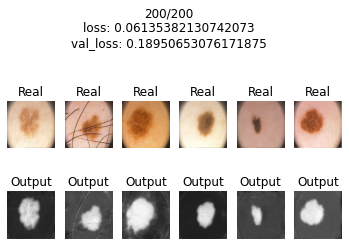

In [ ]:
max_epochs = 200
optim = torch.optim.AdamW(unet_model.parameters(), lr=0.5*1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min', cooldown=5, factor=0.5, patience=15)
losses, val_losses, scores, val_scores = train(unet_model, optim, bce_loss, iou_pytorch, max_epochs, data_tr, data_val, scheduler=scheduler, name='UNet_bce_loss')

In [ ]:
score_model(unet_model, iou_pytorch, data_val)

0.7720000147819519

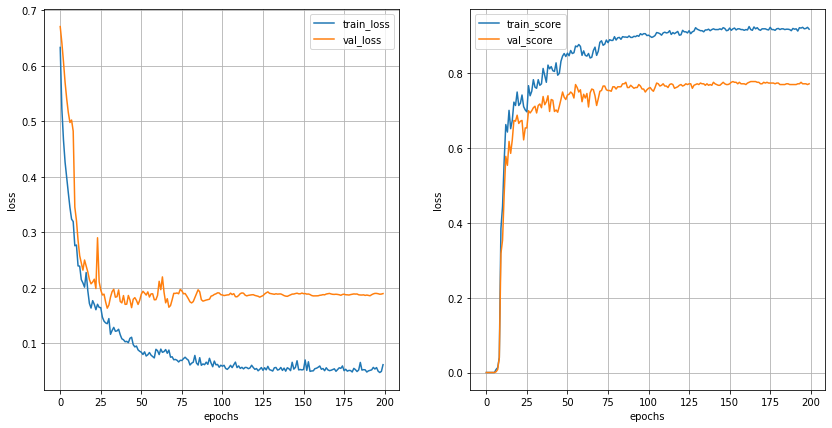

In [ ]:
plot_loss((losses, val_losses), (scores, val_scores))

#### U-Net v2
(Max-Pooling for the downsampling and nearest-neighbor Upsampling for the upsampling.)

In [ ]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            conv_layer(3, 16, 3, 1, 'reflect'),
            conv_layer(16, 16, 3, 1, 'reflect'),
        )
        self.pool0 = nn.MaxPool2d(kernel_size = 2, stride = 2)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            conv_layer(16, 32, 3, 1, 'reflect'),
            conv_layer(32, 32, 3, 1, 'reflect'),
        )
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            conv_layer(32, 64, 3, 1, 'reflect'),
            conv_layer(64, 64, 3, 1, 'reflect'),
        )
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            conv_layer(64, 128, 3, 1, 'reflect'),
            conv_layer(128, 128, 3, 1, 'reflect'),
        )
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = conv_layer(128, 128, 3, 1, 'reflect')

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2, mode='nearest') # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            conv_layer(256, 128, 3, 1, 'reflect'),
            conv_layer(128, 64, 3, 1, 'reflect'),
        )
        self.upsample1 = nn.Upsample(scale_factor=2, mode='nearest') # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            conv_layer(128, 64, 3, 1, 'reflect'),
            conv_layer(64, 32, 3, 1, 'reflect'),
        )
        self.upsample2 = nn.Upsample(scale_factor=2, mode='nearest') # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            conv_layer(64, 32, 3, 1, 'reflect'),
            conv_layer(32, 16, 3, 1, 'reflect'),
        )
        self.upsample3 = nn.Upsample(scale_factor=2, mode='nearest') # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            conv_layer(32, 16, 3, 1, 'reflect'),
            nn.Conv2d(16, 1, kernel_size=3, 
                      padding=1, padding_mode='reflect', stride=1), # no activation
        )

    def forward(self, x):
        # encoder
        conv0 = self.enc_conv0(x)
        x = self.pool0(conv0)

        conv1 = self.enc_conv1(x)
        x = self.pool1(conv1)

        conv2 = self.enc_conv2(x)
        x = self.pool2(conv2)

        conv3 = self.enc_conv3(x)
        x = self.pool3(conv3)

        # bottleneck
        x = self.bottleneck_conv(x)

        # decoder
        x = self.upsample0(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dec_conv0(x)

        x = self.upsample1(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dec_conv1(x)

        x = self.upsample2(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dec_conv2(x)

        x = self.upsample3(x)
        x = torch.cat([x, conv0], dim=1)
        x = self.dec_conv3(x)  # no activation
        return x

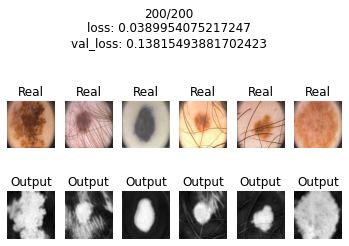

In [ ]:
unet2_model = UNet2().to(device)
max_epochs = 200
optim = torch.optim.AdamW(unet2_model.parameters(), lr=0.5*1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min', cooldown=5, factor=0.5, patience=15)
losses, val_losses, scores, val_scores = train(unet2_model, optim, bce_loss, iou_pytorch, max_epochs, data_tr, data_val, scheduler=scheduler, name='UNet_v2_bce_loss')

In [ ]:
score_model(unet2_model, iou_pytorch, data_val)

0.7660000324249268

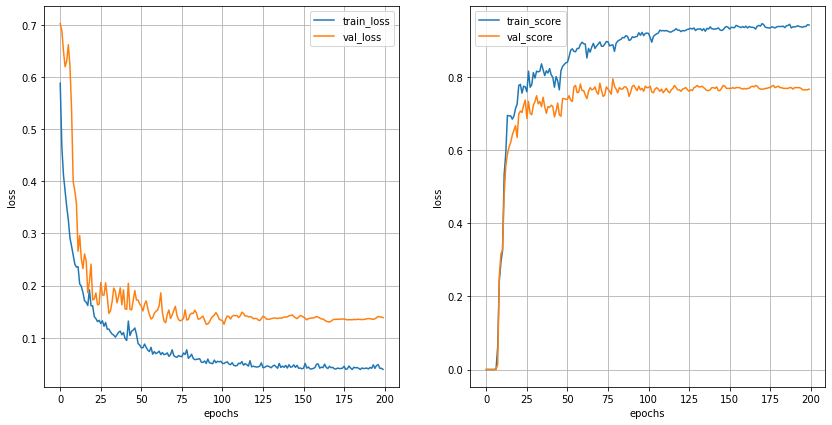

In [ ]:
plot_loss((losses, val_losses), (scores, val_scores))

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


#### U-Net v3 
(Convolutions with stride=2 for the downsampling and transpose-convolutions with stride=2 for the upsampling.)

In [ ]:
class UNet3(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            conv_layer(3, 16, 3, 1, 'reflect'),
            conv_layer(16, 16, 3, 1, 'reflect'),
        )
        self.pool0 = conv_layer(16, 16, kernel_size=2, stride=2)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            conv_layer(16, 32, 3, 1, 'reflect'),
            conv_layer(32, 32, 3, 1, 'reflect'),
        )
        self.pool1 = conv_layer(32, 32, kernel_size=2, stride=2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            conv_layer(32, 64, 3, 1, 'reflect'),
            conv_layer(64, 64, 3, 1, 'reflect'),
        )
        self.pool2 = conv_layer(64, 64, kernel_size=2, stride=2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            conv_layer(64, 128, 3, 1, 'reflect'),
            conv_layer(128, 128, 3, 1, 'reflect'),
        )
        self.pool3 = conv_layer(128, 128, kernel_size=2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = conv_layer(128, 128, 3, 1, 'reflect')

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(128, 128, 2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            conv_layer(256, 128, 3, 1, 'reflect'),
            conv_layer(128, 64, 3, 1, 'reflect'),
        )
        self.upsample1 = nn.ConvTranspose2d(64, 64, 2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            conv_layer(128, 64, 3, 1, 'reflect'),
            conv_layer(64, 32, 3, 1, 'reflect'),
        )
        self.upsample2 = nn.ConvTranspose2d(32, 32, 2, stride=2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            conv_layer(64, 32, 3, 1, 'reflect'),
            conv_layer(32, 16, 3, 1, 'reflect'),
        )
        self.upsample3 = nn.ConvTranspose2d(16, 16, 2, stride=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            conv_layer(32, 16, 3, 1, 'reflect'),
            nn.Conv2d(16, 1, kernel_size=3, 
                      padding=1, padding_mode='reflect', stride=1), # no activation
        )

    def forward(self, x):
        # encoder
        conv0 = self.enc_conv0(x)
        x = self.pool0(conv0)

        conv1 = self.enc_conv1(x)
        x = self.pool1(conv1)

        conv2 = self.enc_conv2(x)
        x = self.pool2(conv2)

        conv3 = self.enc_conv3(x)
        x = self.pool3(conv3)

        # bottleneck
        x = self.bottleneck_conv(x)

        # decoder
        x = self.upsample0(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dec_conv0(x)

        x = self.upsample1(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dec_conv1(x)

        x = self.upsample2(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dec_conv2(x)

        x = self.upsample3(x)
        x = torch.cat([x, conv0], dim=1)
        x = self.dec_conv3(x)  # no activation
        return x

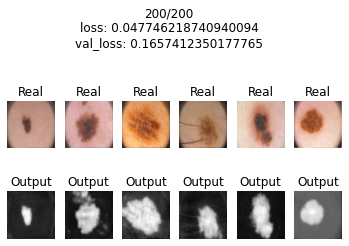

In [ ]:
unet3_model = UNet3().to(device)
max_epochs = 200
optim = torch.optim.AdamW(unet3_model.parameters(), lr=0.5*1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min', cooldown=5, factor=0.5, patience=15)
losses, val_losses, scores, val_scores = train(unet3_model, optim, bce_loss, iou_pytorch, max_epochs, data_tr, data_val, scheduler=scheduler, name='UNet_v3_bce_loss')

In [ ]:
score_model(unet3_model, iou_pytorch, data_val)

0.7540000081062317

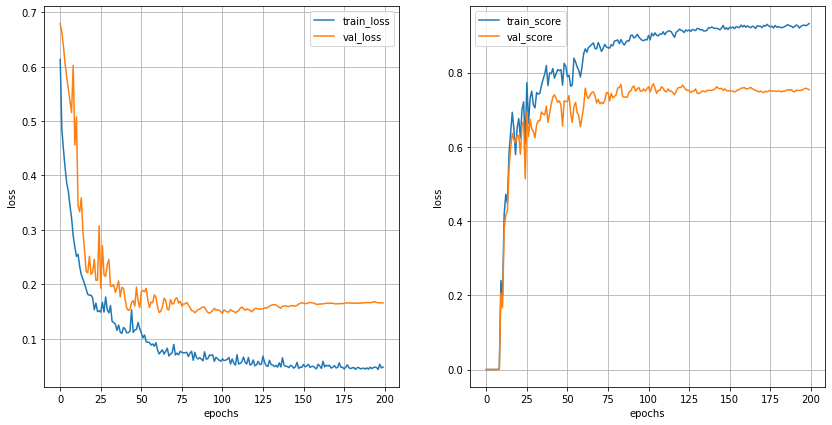

In [ ]:
plot_loss((losses, val_losses), (scores, val_scores))

Сделайте вывод, какая из моделей лучше

## Тестирование на всех лоссах

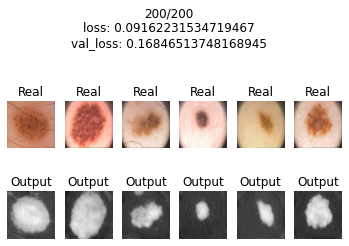

In [ ]:
model = SegNet().to(device)
name = 'SegNet_ss_loss'
max_epochs = 200
optim = torch.optim.AdamW(model.parameters(), lr=0.5*1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min', cooldown=5, factor=0.5, patience=15)
losses, val_losses, scores, val_scores = train(model, optim, ss_loss, iou_pytorch, max_epochs, data_tr, data_val, scheduler=scheduler, name=name)

# Отчет (6 баллов): 




В задании проверены несколько сегментационных моделей на разных лоссах, реализован лосс из статьи, пытающийся сохранить структуру изображения.
В итоге среди всех моделей и лоссов сложно выделить явного фаворита. Наивысшее значение метрики IoU на тесте имеет модель UNet с обычным Upsampling (Nearest Neighbour) и DICE лоссом, наихудший результат у UNet с Transposed Convolutions и Focal лоссом. Все модели обучались приблизительно одинаковое время.

Для умньшения явления переобучения были добавлены аугментации, рандомно отражающие картинку. В результате чего датасет был увеличен в 4 раза. Такие аугментации не должны были сказаться на точности выделения границ на медицинских изображениях.
Модели обучались на 200 эпохах с AdamW и ReduceLROnPlateau Scheduler'ом.
В ходе обучения сохранялись состояния моделей с наивысшим значением IoU, а также конечное состояние после обучения.

В следующей клетке строятся графики лосса и скора модели на разных эпохах при разных видах лосса. 
В принципе, все виды моделей достаточно хорошо сходятся. Модели с DICE лоссом сходятся медленнее всего, но в некоторых случаях это позволяло добиться большего скора. Хорошо показывают себя модели с лоссами BCE и Structural Similiarity из статьи, а также их лосс, усредняющий их (bce_ss_loss). Модели с SS лоссом почти на всех графиках имеют наивысшие показатели IoU после ~100 эпох.

Как было отмечено выше, модели склонны к переобучению при большом числе эпох (>100). Это можно заметить на графиках лосса во время тренировок каждой из моделей. Аугментация данных в данном случае очень помогает в борьбе с переобучением, так как весь датасет состоит из 200 картинок, которые превращаются в 800 благодаря аугментации.

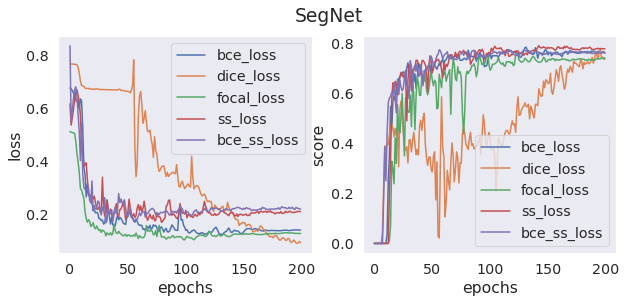

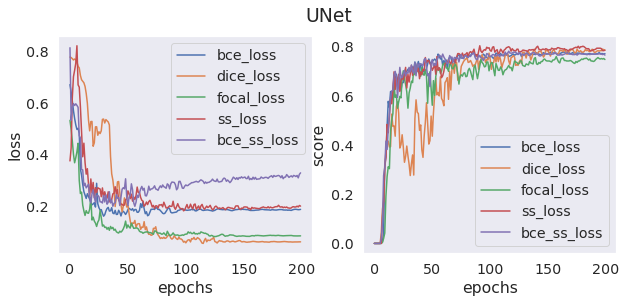

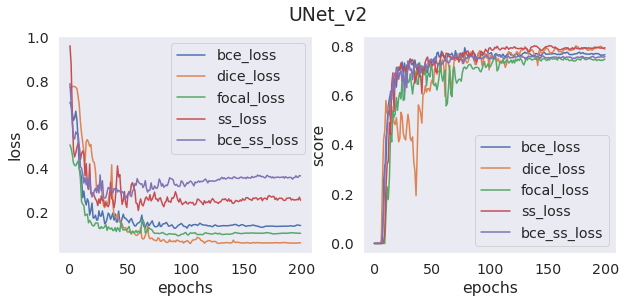

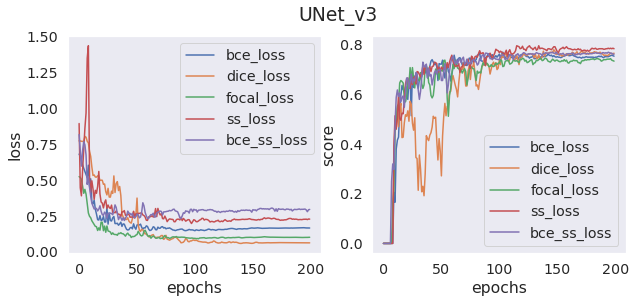

In [ ]:
model_names = ['SegNet', 'UNet', 'UNet_v2', 'UNet_v3']
loss_names = ['bce_loss', 'dice_loss', 'focal_loss', 'ss_loss', 'bce_ss_loss']

for model_name in model_names:
    all_losses = {}
    all_scores = {}
    for loss_name in loss_names:
        name = f'{model_name}_{loss_name}'
        if model_name == 'SegNet':
            model = SegNet().to(device)
        elif model_name == 'UNet':
            model = UNet().to(device)
        elif model_name == 'UNet_v2':
            model = UNet2().to(device)
        elif model_name == 'UNet_v3':
            model = UNet3().to(device)
        optim = torch.optim.AdamW(model.parameters(), lr=1e-4)
        epoch, losses, scores = load_model(model, optim, name)
        all_losses[loss_name] = losses[1] # validation
        all_scores[loss_name] = scores[1]

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    for loss_name in loss_names:
        ax[0].plot(all_losses[loss_name], label=loss_name)
        ax[1].plot(all_scores[loss_name], label=loss_name)

    ax[0].set_ylabel("loss")
    ax[1].set_ylabel("score")
    for a in ax:
        a.legend(loc='best')
        a.set_xlabel("epochs")
        a.grid(which="both")

    plt.suptitle(model_name)

    plt.show()